In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as pp
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import r2_score
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

Açelya Deniz Güngördü

## 1. Introduction

The BigQuery-Geotab Intersection Congestion competition challenges us to predict traffic congestion metrics at various intersections. Our goal is to predict the 20th, 50th, and 80th percentiles for two key metrics:

1.Total time stopped at an intersection

2.Distance between the intersection and the first place a vehicle stopped while waiting

This problem is crucial for urban planning, traffic management, and improving overall transportation efficiency. Our approach will involve thorough data analysis, feature engineering, and the development of advanced machine learning models to make accurate predictions. The objective is to predict congestion, based on an aggregate measure of stopping distance and waiting times, at intersections in 4 major US cities: Atlanta, Boston, Chicago & Philadelphia.

**Data columns:**

**Independent Variables (Features):**

IntersectionId: Represents a unique intersectionID for some intersection of roads within a city.

Latitude: The latitude of the intersection.

Longitude: The longitude of the intersection.

EntryStreetName: The street name from which the vehicle entered towards the intersection.

ExitStreetName: The street name to which the vehicle goes from the intersection.

EntryHeading: Direction to which the car was heading while entering the intersection.

ExitHeading: Direction to which the car went after it went through the intersection.

Hour: The hour of the day.

Weekend: It's weekend or not.

Month: Which Month it is.

Path: It is a concatination in the format: EntryStreetName_EntryHeading ExitStreetName_ExitHeading.

City: Name of the city

**Dependent Variables (Targets):**

TotalTimeStopped_p20: Total time for which 20% of the vehicles had to stop at an intersection.

TotalTimeStopped_p40: Total time for which 40% of the vehicles had to stop at an intersection.

TotalTimeStopped_p50: Total time for which 50% of the vehicles had to stop at an intersection.

TotalTimeStopped_p60: Total time for which 60% of the vehicles had to stop at an intersection.

TotalTimeStopped_p80: Total time for which 80% of the vehicles had to stop at an intersection.

TimeFromFirstStop_p20: Time taken for 20% of the vehicles to stop again after crossing a intersection.

TimeFromFirstStop_p40: Time taken for 40% of the vehicles to stop again after crossing a intersection.

TimeFromFirstStop_p50: Time taken for 50% of the vehicles to stop again after crossing a intersection.

TimeFromFirstStop_p60: Time taken for 60% of the vehicles to stop again after crossing a intersection.

TimeFromFirstStop_p80: Time taken for 80% of the vehicles to stop again after crossing a intersection.

DistanceToFirstStop_p20: How far before the intersection the 20% of the vehicles stopped for the first time.

DistanceToFirstStop_p40: How far before the intersection the 40% of the vehicles stopped for the first time.

DistanceToFirstStop_p50: How far before the intersection the 50% of the vehicles stopped for the first time.

DistanceToFirstStop_p60: How far before the intersection the 60% of the vehicles stopped for the first time.

DistanceToFirstStop_p80: How far before the intersection the 80% of the vehicles stopped for the first time.

**Target Output**: TotalTimeStopped_p50


## 2.Data Exploration and Cleaning

In [2]:
def read_data(path:str, used_columns:list[str]=
              [
                    "Latitude",
                    "Longitude",
                    "EntryStreetName",
                    "ExitStreetName",
                    "EntryHeading",
                    "ExitHeading",
                    "Hour",
                    "Weekend",
                    "Month",
                    #"Path",
                    "TotalTimeStopped_p50",
                    "City"
                ])->pd.DataFrame:

    df = pd.read_csv(path)
    df = df[used_columns]
    df = df.astype({
        'Hour': np.int8,
        'Weekend': np.bool_,
        'Month': np.int8,
        "Latitude": np.float32,
        "Longitude": np.float32,
        "TotalTimeStopped_p50": np.float32
    })
    df.to_pickle(path.replace(".csv", ".pkl"))
    print("Dataset shape:", df.shape)
    return df

In [3]:
# df = read_data("/content/drive/MyDrive/ML_Master/m8project/train.csv")
df = read_data("train.csv")
target_column = "TotalTimeStopped_p50"

Dataset shape: (856387, 11)


In [4]:
print("Columns in the dataset:", df.columns)
print(df.isnull().sum())

print("Number of duplicate rows:", df.duplicated().sum())

Columns in the dataset: Index(['Latitude', 'Longitude', 'EntryStreetName', 'ExitStreetName',
       'EntryHeading', 'ExitHeading', 'Hour', 'Weekend', 'Month',
       'TotalTimeStopped_p50', 'City'],
      dtype='object')
Latitude                   0
Longitude                  0
EntryStreetName         8148
ExitStreetName          6287
EntryHeading               0
ExitHeading                0
Hour                       0
Weekend                    0
Month                      0
TotalTimeStopped_p50       0
City                       0
dtype: int64
Number of duplicate rows: 0


In [5]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.to_pickle("train_cleaned.pkl")

## Visualization

In [ ]:
class TrafficDataVisualizer:
    def __init__(self, data):
        self.data = data

    def create_boxplot(self, columns, title, ylabel):
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=self.data[columns], palette="viridis")
        plt.title(title, fontsize=14, fontweight='bold')
        plt.ylabel(ylabel, fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def create_weekend_boxplot(self):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Weekend', y='TotalTimeStopped_p50', data=self.data, palette="viridis")
        plt.title('Effect of Weekend on Total Time Stopped (50th percentile)', fontsize=14, fontweight='bold')
        plt.xlabel('Weekend (0: No, 1: Yes)', fontsize=12)
        plt.ylabel('Total Time Stopped (seconds)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def create_city_distribution(self):
        plt.figure(figsize=(12, 6))
        sns.countplot(data=self.data, x='City', palette="viridis")
        plt.title('Distribution of Intersections across Cities', fontsize=14, fontweight='bold')
        plt.xlabel('City', fontsize=12)
        plt.ylabel('Number of Intersections', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def create_scatter_plots(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        sns.scatterplot(x=self.data['Latitude'], y=self.data['TotalTimeStopped_p50'], alpha=0.1, ax=ax1, color='teal')
        ax1.set_title('Latitude vs Total Time Stopped (p50)', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Latitude', fontsize=10)
        ax1.set_ylabel('Total Time Stopped (seconds)', fontsize=10)

        sns.scatterplot(x=self.data['Longitude'], y=self.data['TotalTimeStopped_p50'], alpha=0.1, ax=ax2, color='purple')
        ax2.set_title('Longitude vs Total Time Stopped (p50)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Longitude', fontsize=10)
        ax2.set_ylabel('Total Time Stopped (seconds)', fontsize=10)

        plt.tight_layout()
        plt.show()

    def visualize_all(self):
        #time_stopped_columns = ['TotalTimeStopped_p20', 'TotalTimeStopped_p40', 'TotalTimeStopped_p50',
        #                        'TotalTimeStopped_p60', 'TotalTimeStopped_p80']
        #distance_columns = ['DistanceToFirstStop_p20', 'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
        #                    'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80']
        time_stopped_columns = ["TotalTimeStopped_p50"]
        self.create_boxplot(time_stopped_columns, 'Distribution of Total Time Stopped across Percentiles', 'Time (seconds)')
        #self.create_boxplot(distance_columns, 'Distribution of Distance to First Stop across Percentiles', 'Distance (meters)')
        self.create_weekend_boxplot()
        self.create_city_distribution()
        self.create_scatter_plots()

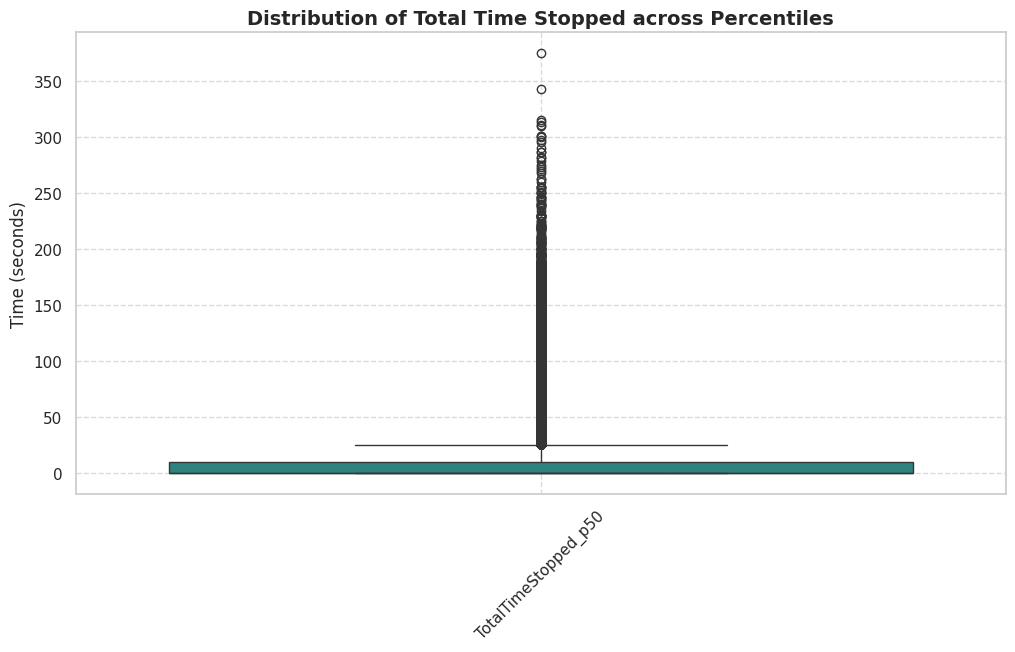

/content/drive/MyDrive/ML_Master/m8project/visualizer.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Weekend', y='TotalTimeStopped_p50', data=self.data, palette="viridis")


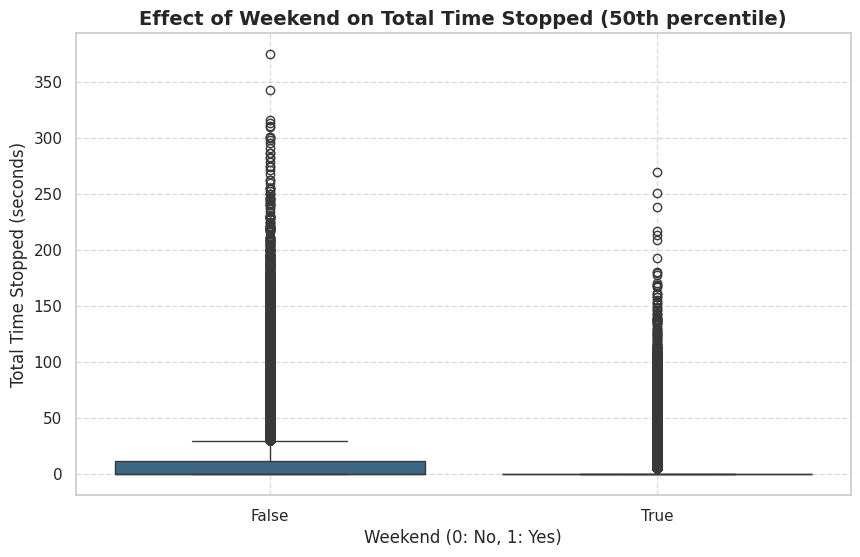

/content/drive/MyDrive/ML_Master/m8project/visualizer.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=self.data, x='City', palette="viridis")


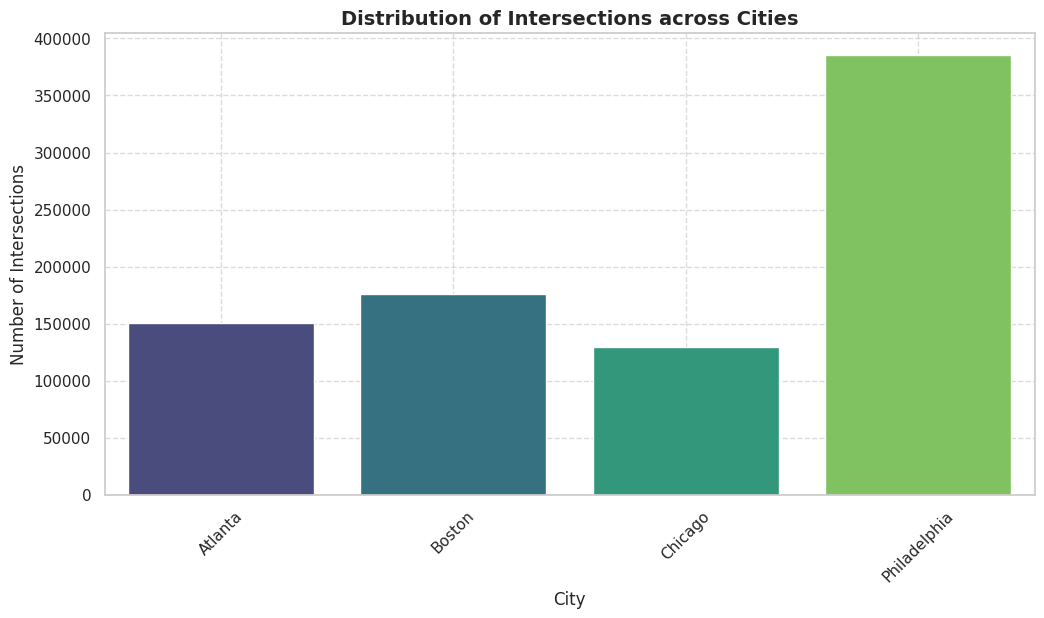

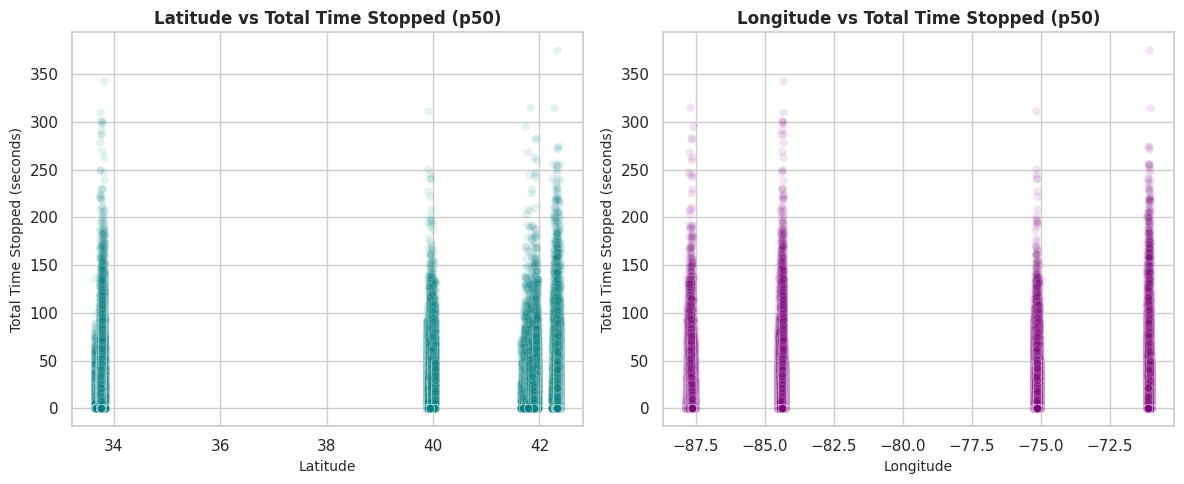

In [ ]:
def create_visuals(df):
  visualizer = TrafficDataVisualizer(df)
  visualizer.visualize_all()
create_visuals(df)

**Overall Insights**

- Geographic Influence: Traffic stops are concentrated in specific areas, likely due to urban centers or major intersections.
- City Differences: The number of intersections varies significantly across cities, impacting traffic flow and stop times.
- Weekend Variability: There is more variability in stopping times on weekends, possibly due to different traffic conditions or events.

### Feature Engineering and Statistical Inference


In [6]:
df['RushHour'] = ((df['Hour'] >= 7) & (df['Hour'] <= 9)) | ((df['Hour'] >= 16) & (df['Hour'] <= 18))
df['DirectionChange'] = (df['EntryHeading'] != df['ExitHeading']).astype(int)

In [7]:
df['Season'] = pd.cut(df['Month'], bins=[0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Fall'])

In [8]:
df = pd.get_dummies(df, columns=['EntryHeading', 'ExitHeading', 'City', 'Season'])

In [9]:
from scipy import stats

def perform_t_test(df, column, condition_column, condition_value_true, condition_value_false, test_name=None):
    """
    Perform a t-test to compare the means of two groups in a DataFrame and print the results.

    Parameters:
    - df: DataFrame containing the data.
    - column: The column on which to perform the t-test.
    - condition_column: The column used to split the data into two groups.
    - condition_value_true: The value in the condition_column that defines the first group.
    - condition_value_false: The value in the condition_column that defines the second group.
    - test_name: A string to describe the test being performed.

    Returns:
    - t_stat: The t-statistic of the test.
    - p_value: The p-value of the test.
    """
    if test_name is None:
      test_name = condition_column
    group1 = df[df[condition_column] == condition_value_true][column]
    group2 = df[df[condition_column] == condition_value_false][column]
    t_stat, p_value = stats.ttest_ind(group1, group2)
    print(f"T-test for {test_name} effect on {column}: t-statistic = {t_stat}, p-value = {p_value}")
    return t_stat, p_value

perform_t_test(df, target_column, 'Weekend', 1, 0,)
perform_t_test(df, target_column, 'RushHour', True, False,)

T-test for Weekend effect on TotalTimeStopped_p50: t-statistic = -85.42352587294107, p-value = 0.0
T-test for RushHour effect on TotalTimeStopped_p50: t-statistic = 80.53696625107739, p-value = 0.0


(np.float64(80.53696625107739), np.float64(0.0))

The negative t-statistic indicates that the average "TotalTimeStopped_p50" is significantly lower on weekends compared to weekdays. A t-statistic of this magnitude suggests a substantial difference between the two groups. The p-value of 0.0 signifies that this result is statistically significant, providing strong evidence against the null hypothesis, which would suggest no difference between weekends and weekdays. This means that the likelihood of observing such a difference by random chance is extremely low.The positive t-statistic indicates that the average "TotalTimeStopped_p50" is significantly higher during rush hours compared to non-rush hours. This substantial positive t-statistic reflects a notable increase in the mean during rush hours. The p-value of 0.0 again confirms the statistical significance of this result, suggesting that the observed difference is not due to random variation.
The analyses reveal that "TotalTimeStopped_p50" is significantly influenced by both the day of the week and the time of day. Specifically, the time stopped is lower on weekends and higher during rush hours. These findings underscore the impact of traffic patterns on stopping times.

What does it all mean? 
In simple terms, the results are telling us that:
- On weekends, vehicles tend to stop for shorter periods of time compared to weekdays.
- During rush hours, vehicles tend to stop for longer periods of time compared to non-rush hours.

## Model Building

### Encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

def label_encode_columns(df, columns):
    """
    Apply label encoding to specified columns in a DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - columns: List of column names to be label encoded.

    Returns:
    - df_encoded: DataFrame with label encoded columns.
    - encoders: Dictionary of LabelEncoders used for each column.
    """
    df_encoded = df.copy()
    encoders = {}

    for column in columns:
        le = LabelEncoder()
        df_encoded[column] = le.fit_transform(df_encoded[column])
        encoders[column] = le

    return df_encoded, encoders

df, encoders = label_encode_columns(df, ['EntryStreetName', 'ExitStreetName'])

In [11]:
df

,Latitude,Longitude,EntryStreetName,ExitStreetName,Hour,Weekend,Month,TotalTimeStopped_p50,RushHour,DirectionChange,...,ExitHeading_SW,ExitHeading_W,City_Atlanta,City_Boston,City_Chicago,City_Philadelphia,Season_Winter,Season_Spring,Season_Summer,Season_Fall
0,33.791660,-84.430031,732,717,0,False,6,0.0,False,0,...,False,False,True,False,False,False,False,True,False,False
1,33.791660,-84.430031,732,717,0,False,6,0.0,False,0,...,False,False,True,False,False,False,False,True,False,False
2,33.791660,-84.430031,732,717,1,False,6,0.0,False,0,...,False,False,True,False,False,False,False,True,False,False
3,33.791660,-84.430031,732,717,1,False,6,0.0,False,0,...,False,False,True,False,False,False,False,True,False,False
4,33.791660,-84.430031,732,717,2,False,6,0.0,False,0,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856382,39.938232,-75.149933,1210,183,17,True,12,0.0,True,1,...,False,True,False,False,False,True,False,False,False,True
856383,39.938232,-75.149933,1210,1189,18,True,12,0.0,True,0,...,False,False,False,False,False,True,False,False,False,True
856384,39.938232,-75.149933,1210,1189,19,True,12,0.0,False,0,...,False,False,False,False,False,True,False,False,False,True
856385,39.938232,-75.149933,181,183,20,True,12,0.0,False,0,...,False,True,False,False,False,True,False,False,False,True


In [12]:
from sklearn.model_selection import train_test_split


X = df.drop(columns=[target_column])
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((673961, 33), (168491, 33), (673961,), (168491,))

In [14]:
def scale_data(scaler_name, X_train, X_test):
    """
    Scale the training data using the specified scaler.

    Parameters:
    - scaler_name: The name of the scaler to use ('StandardScaler', 'MinMaxScaler', etc.).
    - X_train: Training data features to be scaled.
    - y_train: Optional training data target, not used in scaling but kept for consistency.

    Returns:
    - X_train_scaled: Scaled training data features.
    - scaler: The fitted scaler object.
    """
    scaler_class = getattr(pp, scaler_name)
    scaler = scaler_class()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled,X_test_scaled, scaler

scaler_name = "StandardScaler"

X_train, X_test, scaler = scale_data(scaler_name=scaler_name,X_train=X_train, X_test = X_test)

In [15]:
def plot_predictions(y_true, y_pred, title=''):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color='blue', alpha=0.6, label='Predictions')
    ax = plt.gca()
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2, label='y = x', transform=ax.transAxes)

    plt.title(title)
    plt.xlabel('Gerçek Değerler')
    plt.ylabel('Tahmin Edilen Değerler')

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    plt.text(0.8, 0.15, f'$R^2$ = {r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.text(0.8, 0.1, f'$mse$ = {mse:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

ps: It took too long to train the models. I noticed at the last hour that the writings on the plots were in Turkish. I didn't have time to change them. "Gerçek değerler" means "Actual Values" and "Tahmin Edilen Değerler" means "Predicted Values".

Mean Squared Error: 230.1639343461095


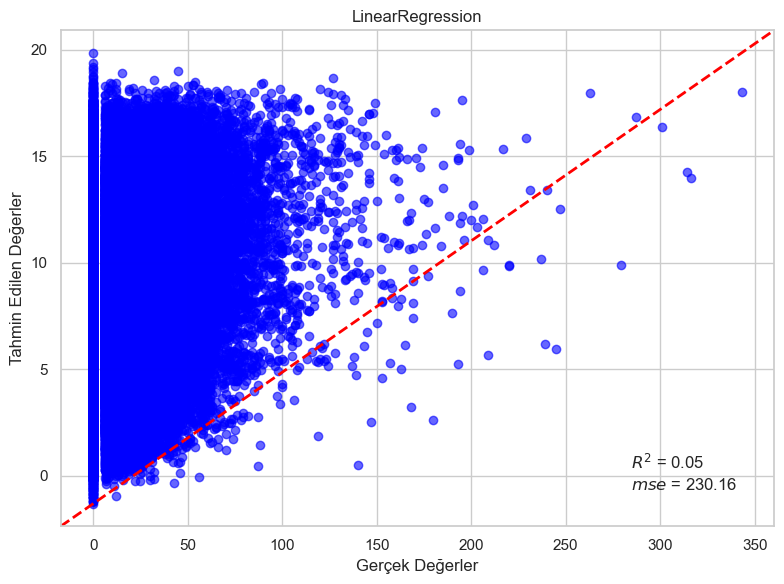

In [16]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_model_predictions = linear_model.predict(X_test)

linear_model_mse = mean_squared_error(y_test, linear_model_predictions)
print("Mean Squared Error:", linear_model_mse)
plot_predictions(y_test, linear_model_predictions, "LinearRegression")

Mean Squared Error: 223.02394


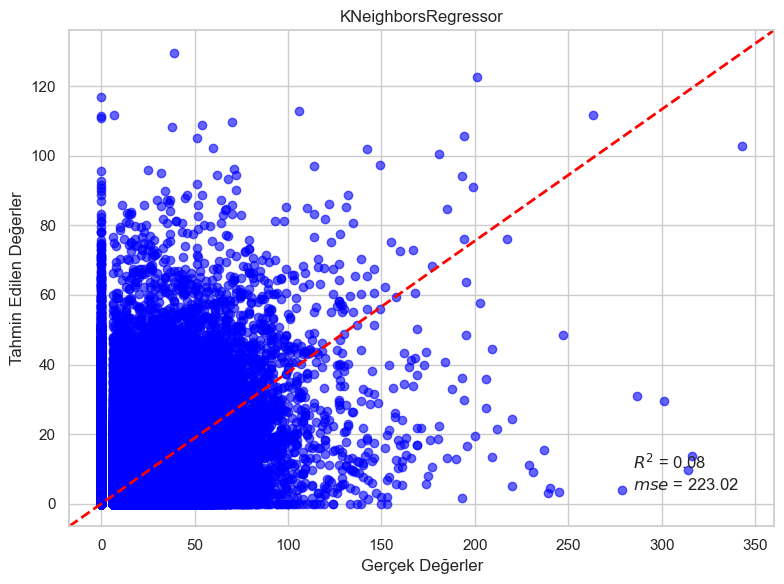

In [17]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_mse = mean_squared_error(y_test, knn_predictions)
print("Mean Squared Error:", knn_mse)
plot_predictions(y_test, knn_predictions, "KNeighborsRegressor")

Mean Squared Error: 95.7873738466743


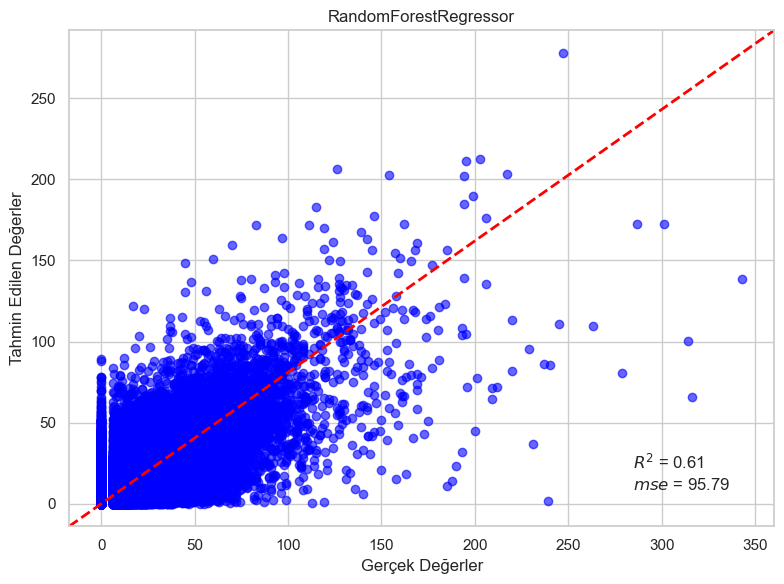

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
print("Mean Squared Error:", rf_mse)
plot_predictions(y_test, rf_predictions, "RandomForestRegressor")

## Model Evaluation



- R-squared (R²): R-squared measures the proportion of the variance in the outcome variable that is explained by the predictor variable(s). 
  - A high R-squared value indicates a good fit of the model to the data.
- p-value: The p-value indicates the probability of observing the estimated slope coefficient (or more extreme) assuming that the true slope is zero. 
  - A low p-value (typically < 0.05) indicates that the slope coefficient is statistically significant.

**LINEAR REGRESSION**
 **Interpretation**

Suppose we have a linear regression model that predicts the relationship between the number of hours studied (x) and the exam score (y). 
The model is:y = 50 + 2x + ε

In this example:
- The intercept (β0) is 50, indicating that the expected exam score is 50 when the number of hours studied is zero.
- The slope coefficient (β1) is 2, indicating that for every additional hour studied, the exam score is expected to increase by 2 points.
- If the R-squared value is 0.08, it means that 8% of the variance in the exam score is explained by the number of hours studied.
- If the p-value is 0.01, it means that the slope coefficient is statistically significant, and we can reject the null hypothesis that the true slope is zero.

**KNN Interpretation**
- Mean Squared Error (MSE): The MSE is 223.02, which measures the average squared difference between the predicted and actual values. 
   - A lower MSE indicates better model performance. In this case, the MSE suggests that there is a significant error in the predictions.
- R-squared (R²): The R² value is 0.08, indicating that only 8% of the variance in the actual values is explained by the model. This is quite low, suggesting that the model does not fit the data well.

**RANDOM FOREST Interpretation**


- R² (R-squared) = 0.61: This indicates that 61% of the variance in the actual values is explained by the model. This is a moderate level of explanatory power, suggesting the model captures some of the underlying patterns but may still miss others.
- Mean Squared Error (MSE) = 95.79: This is the average of the squares of the errors, which are the differences between predicted and actual values. A lower MSE indicates better model performance. In this context, an MSE of 95.79 suggests that the model's predictions are reasonably close to the actual values, but there is room for improvement.

**Model Strengths**

Handling Non-Linearity: Random Forest can capture non-linear relationships between features and the target variable.

Robustness: It is less likely to overfit compared to individual decision trees due to averaging multiple trees.

**Potential Improvements**
- Feature Engineering: Adding or transforming features might improve the model's performance.
- Hyperparameter Tuning: Adjusting parameters like the number of trees or the maximum depth of each tree could enhance accuracy.

Best model is **Random Forest**